## Shark attacks

The objective of this notebook is to clean and analyze the data and train a classification algorithim to predicct if an attack is going to be fatal or not

-----------------------

First we are going to do some data cleaning

We are going to use the 'attacks.cvs' file because it has de information we need for this proyect

In [115]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [116]:
df  = pd.read_csv(r'/home/kotarum/Documentos/Mini_proyect/archive/attacks.csv', encoding='latin1')

Now that we have our data let's have a look

In [117]:
print(df)

      Case Number         Date    Year        Type    Country  \
0      2018.06.25  25-Jun-2018  2018.0     Boating        USA   
1      2018.06.18  18-Jun-2018  2018.0  Unprovoked        USA   
2      2018.06.09  09-Jun-2018  2018.0     Invalid        USA   
3      2018.06.08  08-Jun-2018  2018.0  Unprovoked  AUSTRALIA   
4      2018.06.04  04-Jun-2018  2018.0    Provoked     MEXICO   
...           ...          ...     ...         ...        ...   
25718         NaN          NaN     NaN         NaN        NaN   
25719         NaN          NaN     NaN         NaN        NaN   
25720         NaN          NaN     NaN         NaN        NaN   
25721         NaN          NaN     NaN         NaN        NaN   
25722          xx          NaN     NaN         NaN        NaN   

                  Area                        Location     Activity  \
0           California     Oceanside, San Diego County     Paddling   
1              Georgia  St. Simon Island, Glynn County     Standing   
2     

Now that we have our db let's standarize the header so we can work it better

In [118]:
df.columns = df.columns.str.lower()
df.columns = df.columns.str.lower().str.replace(" ", "_").str.replace(".", "_").str.replace(":","_")

Let's see what type and how many columns we have:

In [119]:
df.dtypes

case_number                object
date                       object
year                      float64
type                       object
country                    object
area                       object
location                   object
activity                   object
name                       object
sex_                       object
age                        object
injury                     object
fatal_(y/n)                object
time                       object
species_                   object
investigator_or_source     object
pdf                        object
href_formula               object
href                       object
case_number_1              object
case_number_2              object
original_order            float64
unnamed__22                object
unnamed__23                object
dtype: object

We have a lot of NaN and some columns will not be useful to this analysis because it does not have an influence in the fatal column, such us the pdf or the case number. Let's drop some columns!

In [120]:
dropcolumns = ['unnamed__22', 'unnamed__23', 'date','area','pdf', 'href', 'investigator_or_source', 'href_formula', 'case_number_1', 'case_number_2', 'original_order', 'injury', 'age', 'name', 'case_number', 'location', 'year']
# Remove leading and trailing whitespaces from column names
df = df.drop(dropcolumns, axis=1)

In [121]:
df = df.rename(columns={'fatal_(y/n)':'fatal', 'sex_':'sex', 'species_':'species'})

Let's check the nulls and clean them

In [122]:
df.isna().sum()

type        19425
country     19471
activity    19965
sex         19986
fatal       19960
time        22775
species     22259
dtype: int64

In [123]:
df = df.dropna(how='all')
df.isna().sum()

type           4
country       50
activity     544
sex          565
fatal        539
time        3354
species     2838
dtype: int64

In [124]:
df = df.dropna()
df.isna().sum()

type        0
country     0
activity    0
sex         0
fatal       0
time        0
species     0
dtype: int64

Now we shouldn't have any nulls left, lets get to work with the column 'time'.

This column has many diferent entries and variables, to have a better variance later we are going to group all cases in 6 categories:

In [125]:
def convert_to_time_category(time_str):
    if pd.isnull(time_str):  # Check if the value is missing
        return 'Unknown'             # Return an empty string for missing values

    if str(time_str).lower() in ['morning', 'afternoon', 'late afternoon', 'night', 'evening']:
        return time_str.lower()
    try:
        time_dt = pd.to_datetime(time_str, format='%Hh%M', errors='raise')

        if 6 <= time_dt.hour < 12:
            return 'morning'
        elif 12 <= time_dt.hour < 18:
            return 'afternoon'
        elif 18 <= time_dt.hour < 21:
            return 'evening'
        else:
            return 'night'
    except ValueError:
        return 'Unknown'

# Replace missing values with empty strings
df['time'].fillna('Unknown', inplace=True)

# Apply the convert_to_time_category() function to the 'time' column
df['time'] = df['time'].apply(convert_to_time_category)

Great! Let's see how the column time distributed just to check if something is wrong

<Axes: xlabel='time', ylabel='Count'>

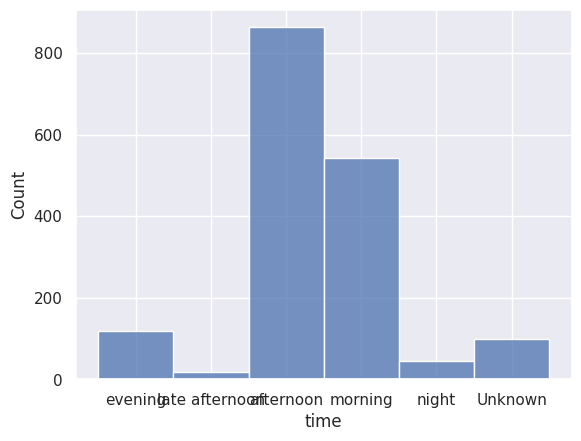

In [126]:
import seaborn as sns


sns.histplot(data=df, x='time')

Now will be cleaning the column 'type'

In [127]:
df['type'].unique()

array(['Boating', 'Unprovoked', 'Provoked', 'Invalid', 'Questionable',
       'Boat', 'Sea Disaster'], dtype=object)

Less variables, better predictions

In [128]:
df['type'] = df['type'].replace({'Boatomg' : 'Boating', 'Questionable' : 'Unprovoked', 'Boat' : 'Boating', 'Invalid' : 'Unprovoked'})
df['type'].unique()

array(['Boating', 'Unprovoked', 'Provoked', 'Sea Disaster'], dtype=object)

<Axes: xlabel='type', ylabel='Count'>

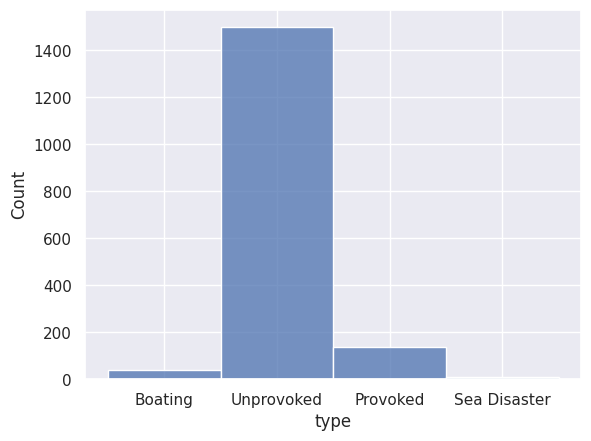

In [129]:
sns.histplot(data=df, x='type')

Now will be cleaning the 'sex' column

In [130]:
df['sex'].unique()

array(['F', 'M', 'lli'], dtype=object)

In [131]:
df['sex'] = df['sex'].str.lower().str.strip()
df.loc[~df['sex'].isin(['f', 'm']), 'sex'] = np.nan
df['sex'].fillna('default_value', inplace=True)
df['sex'].replace({'default_value': 'other'}, inplace=True)

df['sex'].unique()


array(['f', 'm', 'other'], dtype=object)

<Axes: xlabel='sex', ylabel='Count'>

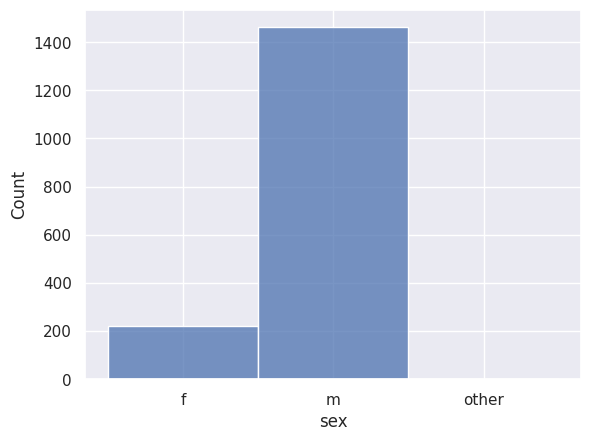

In [132]:
sns.histplot(data=df, x='sex')

'country' is next and we are going to group by continent

In [133]:
df['country'].unique()

array(['USA', 'BRAZIL', 'AUSTRALIA', 'ENGLAND', 'COSTA RICA', 'MALDIVES',
       'SOUTH AFRICA', 'BAHAMAS', 'NEW CALEDONIA', 'CUBA', 'NEW ZEALAND',
       'SPAIN', 'REUNION', 'INDONESIA', 'COLUMBIA', 'EGYPT',
       'FRENCH POLYNESIA', 'ECUADOR', 'THAILAND', 'FRANCE', 'MEXICO',
       'JAMAICA', 'ITALY', 'PAPUA NEW GUINEA', 'RUSSIA', 'SEYCHELLES',
       'VIETNAM', 'MOZAMBIQUE', 'SCOTLAND', 'UNITED KINGDOM', 'TAIWAN',
       'GUAM', 'CROATIA', 'PANAMA', 'SOLOMON ISLANDS', 'FIJI', 'TONGA',
       'ST. MAARTIN', 'GRAND CAYMAN', 'VANUATU', 'VENEZUELA',
       'MICRONESIA', 'TURKS & CAICOS', 'OKINAWA', 'MARSHALL ISLANDS',
       'MAURITIUS', 'EGYPT / ISRAEL', 'HONG KONG', 'JAPAN', 'CHILE',
       'SOUTH KOREA', 'ISRAEL', 'SENEGAL', 'NEW BRITAIN',
       'JOHNSTON ISLAND', 'SOUTH PACIFIC OCEAN', 'PALAU',
       'FEDERATED STATES OF MICRONESIA', 'GREECE', 'BRITISH WEST INDIES',
       'MADAGASCAR', 'MID ATLANTIC OCEAN', 'PERSIAN GULF', 'BERMUDA',
       'NORTH PACIFIC OCEAN', 'NICARAGUA ', '

In [134]:
df['country'] = df['country'].str.upper()

In [135]:
df['country'] = df['country'].str.strip()
df['country'].unique()

array(['USA', 'BRAZIL', 'AUSTRALIA', 'ENGLAND', 'COSTA RICA', 'MALDIVES',
       'SOUTH AFRICA', 'BAHAMAS', 'NEW CALEDONIA', 'CUBA', 'NEW ZEALAND',
       'SPAIN', 'REUNION', 'INDONESIA', 'COLUMBIA', 'EGYPT',
       'FRENCH POLYNESIA', 'ECUADOR', 'THAILAND', 'FRANCE', 'MEXICO',
       'JAMAICA', 'ITALY', 'PAPUA NEW GUINEA', 'RUSSIA', 'SEYCHELLES',
       'VIETNAM', 'MOZAMBIQUE', 'SCOTLAND', 'UNITED KINGDOM', 'TAIWAN',
       'GUAM', 'CROATIA', 'PANAMA', 'SOLOMON ISLANDS', 'FIJI', 'TONGA',
       'ST. MAARTIN', 'GRAND CAYMAN', 'VANUATU', 'VENEZUELA',
       'MICRONESIA', 'TURKS & CAICOS', 'OKINAWA', 'MARSHALL ISLANDS',
       'MAURITIUS', 'EGYPT / ISRAEL', 'HONG KONG', 'JAPAN', 'CHILE',
       'SOUTH KOREA', 'ISRAEL', 'SENEGAL', 'NEW BRITAIN',
       'JOHNSTON ISLAND', 'SOUTH PACIFIC OCEAN', 'PALAU',
       'FEDERATED STATES OF MICRONESIA', 'GREECE', 'BRITISH WEST INDIES',
       'MADAGASCAR', 'MID ATLANTIC OCEAN', 'PERSIAN GULF', 'BERMUDA',
       'NORTH PACIFIC OCEAN', 'NICARAGUA', 'A

In [136]:
df['country'].fillna(value='USA', inplace=True)

In [137]:
 country_mapping = {
    'USA': 'North America',
    'BRAZIL': 'South America',
    'AUSTRALIA': 'Oceania',
    'ENGLAND': 'Europe',
    'SOUTH AFRICA': 'Africa',
    'COSTA RICA': 'North America',
    'MALDIVES': 'Asia',
    'BAHAMAS': 'North America',
    'CUBA': 'North America',
    'MAURITIUS': 'Africa',
    'NEW ZEALAND': 'Oceania',
    'JAPAN': 'Asia',
    'ST HELENA, BRITISH OVERSEAS TERRITORY': 'Africa',
    'SPAIN': 'Europe',
    'UNITED ARAB EMIRATES': 'Asia',
    'MEXICO': 'North America',
    'REUNION': 'Africa',
    'INDONESIA': 'Asia',
    'NEW CALEDONIA': 'Oceania',
    'COLUMBIA': 'South America',
    'EGYPT': 'Africa',
    'FRENCH POLYNESIA': 'Oceania',
    'FIJI': 'Oceania',
    'DOMINICAN REPUBLIC': 'North America',
    'ECUADOR': 'South America',
    'MOZAMBIQUE': 'Africa',
    'THAILAND': 'Asia',
    'FRANCE': 'Europe',
    'ISRAEL': 'Asia',
    'JAMAICA': 'North America',
    'ITALY': 'Europe',
    'PAPUA NEW GUINEA': 'Oceania',
    'RUSSIA': 'Europe',
    'SEYCHELLES': 'Africa',
    'TURKS & CAICOS': 'North America',
    'TONGA': 'Oceania',
    'SOUTH KOREA': 'Asia',
    'VIETNAM': 'Asia',
    'MADAGASCAR': 'Africa',
    'UNITED ARAB EMIRATES (UAE)': 'Asia',
    'PANAMA': 'North America',
    'SCOTLAND': 'Europe',
    'UNITED KINGDOM': 'Europe',
    'TAIWAN': 'Asia',
    'GUAM': 'Oceania',
    'PHILIPPINES': 'Asia',
    'CROATIA': 'Europe',
    'SOLOMON ISLANDS': 'Oceania',
    'ST. MAARTIN': 'North America',
    'GRAND CAYMAN': 'North America',
    'VANUATU': 'Oceania',
    'MEXICO ': 'North America',
    'VENEZUELA': 'South America',
    'MICRONESIA': 'Oceania',
    'OKINAWA': 'Asia',
    'MARSHALL ISLANDS': 'Oceania',
    'EGYPT / ISRAEL': 'Africa',
    'HONG KONG': 'Asia',
    'CHILE': 'South America',
    'GRENADA': 'North America',
    'IRAQ': 'Asia',
    'BERMUDA': 'North America',
    'SENEGAL': 'Africa',
    'TURKEY': 'Asia',
    'NEW BRITAIN': 'Oceania',
    'PACIFIC OCEAN ': 'Oceania',
    'PALAU': 'Oceania',
    'FEDERATED STATES OF MICRONESIA': 'Oceania',
    'GREECE': 'Europe',
    'BRITISH WEST INDIES': 'North America',
    'MID ATLANTIC OCEAN': 'Atlantic Ocean',
    'PERSIAN GULF': 'Asia',
    'NORTH PACIFIC OCEAN': 'Pacific Ocean',
    'NICARAGUA ': 'North America',
    'AMERICAN SAMOA': 'Oceania',
    'KENYA': 'Africa',
    'PACIFIC OCEAN': 'Oceania',
    'NORTH ATLANTIC OCEAN ': 'Atlantic Ocean',
    'THE BALKANS': 'Europe',
    'ARGENTINA': 'South America',
    'SUDAN': 'Africa',
    'EL SALVADOR': 'North America',
    'SAUDI ARABIA': 'Asia',
    'SOUTH ATLANTIC OCEAN': 'Atlantic Ocean',
    'IRAN': 'Asia',
    'GUYANA': 'South America',
    'HAITI': 'North America',
    'IRELAND': 'Europe',
    'MONTENEGRO': 'Europe',
    'NICARAGUA': 'South America',
    'EGYPT': 'Africa',
    'YEMEN': 'Asia',
    'CANADA': 'North America',
    'INDIA': 'Asia',
    'GUINEA': 'Africa',
    'SRI LANKA': 'Asia',
    'BARBADOS': 'North America',
    'PUERTO RICO': 'South America',
    'PALESTINIAN TERRITORIES': 'Asia',
    'SAMOA': 'Oceania',
    'SINGAPORE': 'Asia',
    'JOHNSTON ISLAND': 'Asia',
    'SOUTH PACIFIC OCEAN': 'Pacific Ocean',
    'Atlantic Ocean': 'Atlantic Ocean',
    'TANZANIA': 'Africa',
    'ANDAMAN / NICOBAR ISLANDAS': 'Asia',
    'SOLOMON ISLANDS / VANUATU': 'Oceania',
    'ANDAMAN ISLANDS': 'Asia'
 }

In [138]:
df['country'] = df['country'].replace(country_mapping)
df['country'].unique()

array(['North America', 'South America', 'Oceania', 'Europe', 'Asia',
       'Africa', 'Pacific Ocean', 'Atlantic Ocean'], dtype=object)

In [139]:
drop = ['Atlantic Ocean', 'Pacific Ocean', 'NORTH ATLANTIC OCEAN', 'CARIBBEAN SEA', 'RED SEA?']
df = df[~df['country'].isin(drop)]

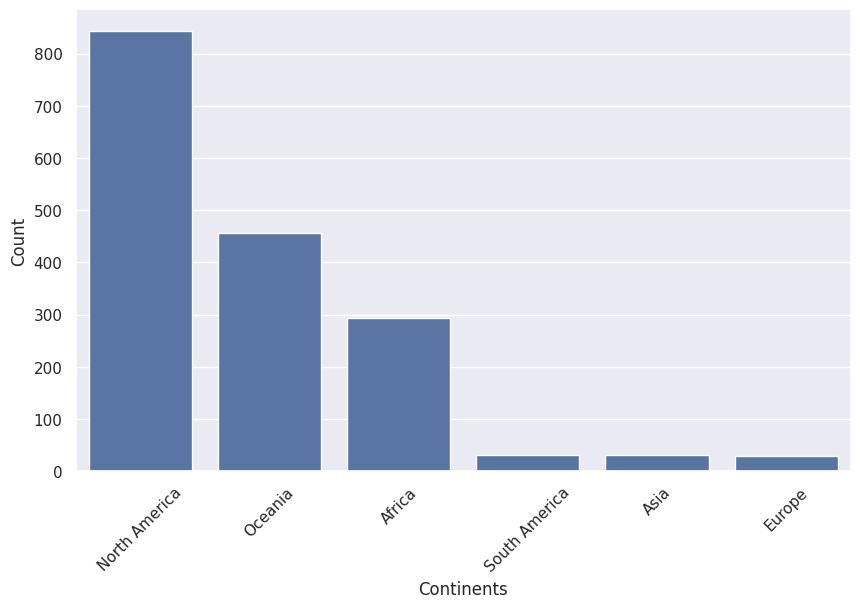

In [140]:
x = df['country'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=x.index, y=x.values)
plt.xlabel('Continents')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Now the 'fatal' column

In [141]:
df['fatal'].unique()

array(['N', 'Y', 'M', '2017', ' N', 'UNKNOWN'], dtype=object)

In [142]:
df['fatal'].value_counts()

fatal
N          1424
Y           254
 N            2
M             1
2017          1
UNKNOWN       1
Name: count, dtype: int64

In [143]:
fatal_column = {'M' : 'N',
                'UNKNOWN' : 'N',
                ' N' : 'N',
                '2017' : 'N',}

In [144]:
df['fatal'] = df['fatal'].replace(fatal_column)
df['fatal'].unique()

array(['N', 'Y'], dtype=object)

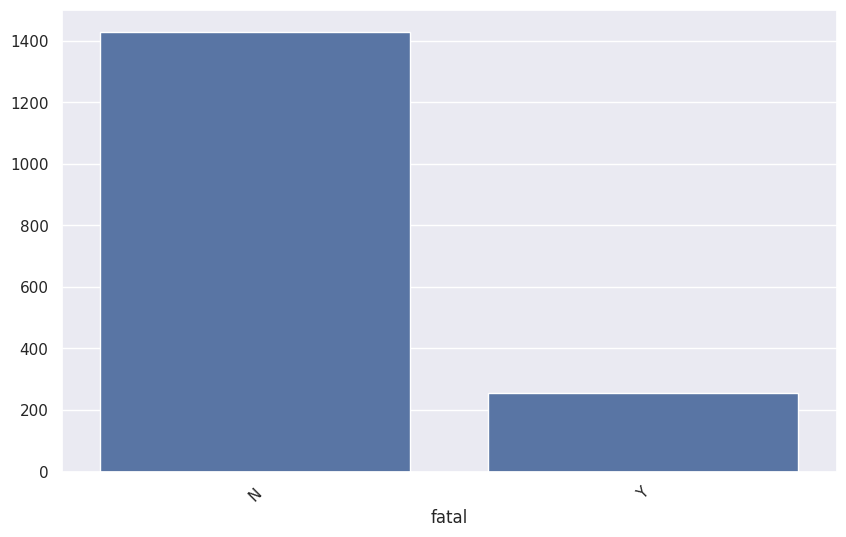

In [145]:
x = df['fatal'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=x.index, y=x.values)
plt.xticks(rotation=45)
plt.show()

Now the 'activity'

In [146]:
df['activity'].unique()

array(['Paddling', 'Swimming', 'Walking', 'Feeding sharks', 'Fishing',
       'Surfing', 'Scuba diving', 'Paddle-skiing',
       'Stand-Up Paddleboarding', 'Wading', 'Spearfishing', 'Diving',
       'Night bathing', 'Kayaking / Fishing', 'Kayaking', 'Snorkeling',
       'SUP', 'Body boarding', 'Grabbing shark for a selfie',
       'Scuba Diving', 'Surf skiing ', 'Surf fishing', 'Floating',
       'SUP Foil boarding', 'Kite surfing', 'Floating in tube',
       'Standing', 'Teasing a shark', 'Surf-skiing', 'Paddle boarding',
       'Kayak Fishing', 'Kayak fishing', 'Scallop diving on hookah',
       'Body boarding ', 'Playing in the water', 'Body Boarding',
       'Boogie boarding', 'Playing', 'Standing / Snorkeling',
       'Hand feeding sharks', 'Rowing', 'Shark fishing', 'Kayaking ',
       'Fishing ', 'Body surfing', 'Kitesurfing', 'Kiteboarding',
       'Diving for crayfish', 'Diving ', 'Swimming / snorkeling',
       'Diving for Abalone', 'Casting a net',
       'Longline fishing f

In [147]:
df['activity'].value_counts()

activity
Surfing                                                                     453
Swimming                                                                    229
Spearfishing                                                                123
Fishing                                                                      70
Wading                                                                       51
                                                                           ... 
Wading / Surfing                                                              1
Body boarding or surfing                                                      1
Scuba diving (submerged riding a scooter)                                     1
Swimming or paddle boarding                                                   1
Swimming in section of river used for washing clothes & cooking utensils      1
Name: count, Length: 394, dtype: int64

In [148]:
df['activity'] = df['activity'].str.lower()
df['activity'] = df['activity'].str.strip()

In this case I will group the activities by related categories and try to have some coherent classes

In [149]:
import re
activity_mapping = {
    'Water Activities': r'(surf|swim|dive|paddle|snorkel|kayak|float|skim|board|sail|kite|row)',
    'Fishing Activities': r'(fish|angling)',
    'Walking Activities': r'(walk|hike)',
    'Sports Activities': r'(play|run|jump|cycle|climb)',
    'Adventure Activities': r'(explore|adventure|trek)',
    'Relaxing Activities': r'(relax|sunbathe|meditate|stroll)',
    'Unknown Activities': r'.*'
}
df['activity'] = df['activity'].apply(lambda x: next((category for category, regex in activity_mapping.items() if re.search(regex, x, flags=re.IGNORECASE)), 'Unknown Activities'))

In [150]:
df['activity'].value_counts()

activity
Water Activities      1075
Unknown Activities     321
Fishing Activities     261
Sports Activities       16
Walking Activities      10
Name: count, dtype: int64

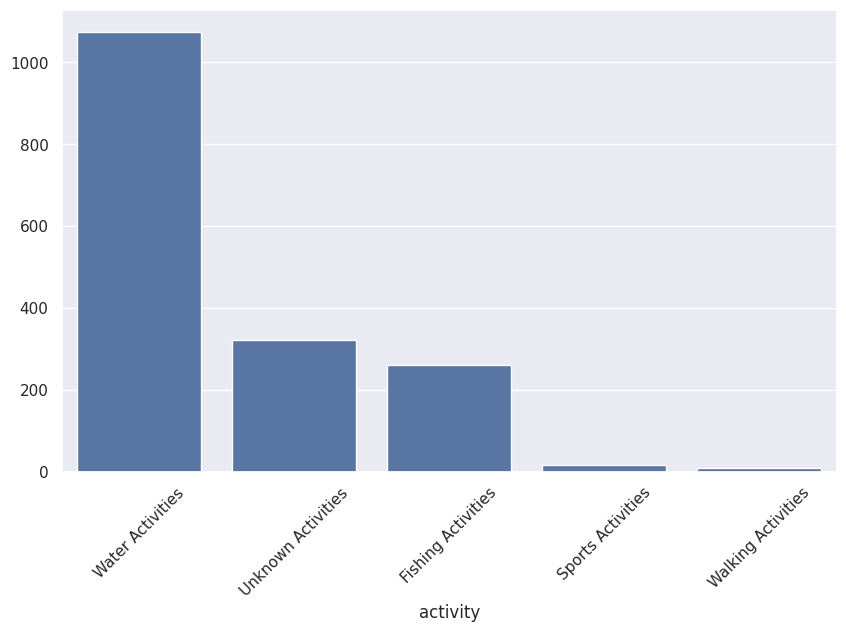

In [151]:
x = df['activity'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=x.index, y=x.values)
plt.xticks(rotation=45)
plt.show()

Lastly, 'species'

In [152]:
df['species'].unique()

array(['White shark', 'Tiger shark', "Bull shark, 6'", 'Grey reef shark',
       'Invalid incident', 'Shark involvement not confirmed',
       'Questionable', '3 m shark', 'White shark, 3.5 m',
       'White shark, 2.5 m', 'Bull shark', "Tiger shark, 12'",
       'Wobbegong shark', '3.5 m shark', '1.8 m shark',
       'Juvenile white shark,  2.7 to 3.2 m', 'Bull shark, 2 m',
       'Possibly a wobbegong', 'Bull shark, 3 m ', 'Grey reef shark. 2 m',
       'small shark', 'White shark, 4.6 m', '2 m shark',
       'Wobbegong shark, 1 m', 'White shark, 4.5 m',
       'Spinner shark, 4 to 5 feet', 'Tiger shark, 8 to 10 feet',
       "8' shark", "5' shark", "4' to 5' shark", "5' to 6' shark",
       'White shark, 3 to 3.5m ', 'White shark, 3 m',
       "White shark, 5' to 7'", 'Possibly a juvenile blacktip shark',
       "4' shark", "White shark, 10'", "Blue shark 6'",
       "White shark, 11' to 13'", "White shark, 8' to 10'",
       "White shark, 9'", "Bull shark, 4' to 5'", 'Bull shark, 2

In [153]:
df['species'].value_counts()

species
White shark                              92
Tiger shark                              40
4' shark                                 35
Bull shark                               33
1.8 m [6'] shark                         23
                                         ..
4.5 m & 5 m white shark                   1
2.5 m [8.25'] bull shark                  1
Bronze whaler shark, 2.4 m [8']           1
1.8 m to 2.4 m [6' to 8'] white shark     1
White sharks                              1
Name: count, Length: 935, dtype: int64

In this case, all the entries that have that word in it will be categorize correspondly

In [154]:
shark_mapping = {
    'White Shark': r'(white)',
    'Tiger Shark': r'(tiger)',
    'Bull Shark': r'(bull)',
    'Reef Shark': r'(reef)',
    'Wobbegong Shark': r'(wobbegong)',
    'Blue Shark': r'(blue)',
    'Nurse Shark': r'(nurse)',
    'Unknown Shark': r'.*'
}
df['species'] = df['species'].apply(lambda x: next((category for category, regex in shark_mapping.items() if re.search(regex, x, flags=re.IGNORECASE)), 'Unknown Shark'))

In [155]:
df['species'].value_counts()

species
Unknown Shark      836
White Shark        446
Tiger Shark        171
Bull Shark         122
Nurse Shark         40
Reef Shark          32
Wobbegong Shark     21
Blue Shark          15
Name: count, dtype: int64

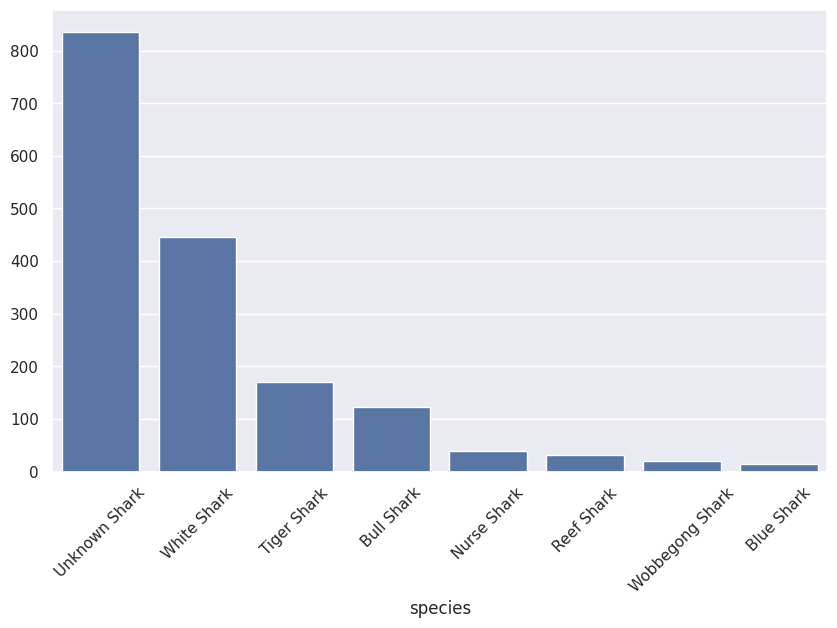

In [156]:
x = df['species'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=x.index, y=x.values)
plt.xticks(rotation=45)
plt.show()

------------------

## EDA

Now we have a clean database we can use to our analisys, so lets do some data exploration and see what the data is trying to say

In [157]:
df.value_counts()

type        country        activity          sex  fatal  time            species      
Unprovoked  North America  Water Activities  m    N      afternoon       Unknown Shark    140
                                                         morning         Unknown Shark     78
                                                                         White Shark       38
            Africa         Water Activities  m    N      afternoon       White Shark       37
            North America  Water Activities  m    N      afternoon       White Shark       37
                                                                                         ... 
            Asia           Water Activities  m    Y      afternoon       White Shark        1
                                                                         Unknown Shark      1
                                                                         Bull Shark         1
                                                                   

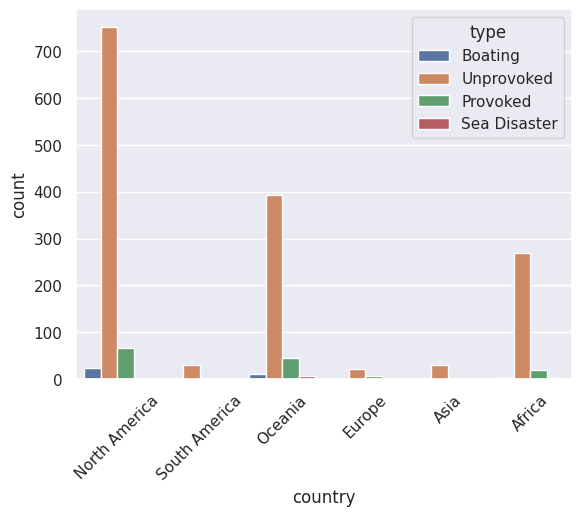

In [158]:
sns.set(style="darkgrid")
sns.countplot(data=df, x='country', hue='type')
plt.xticks(rotation=45)
plt.show()


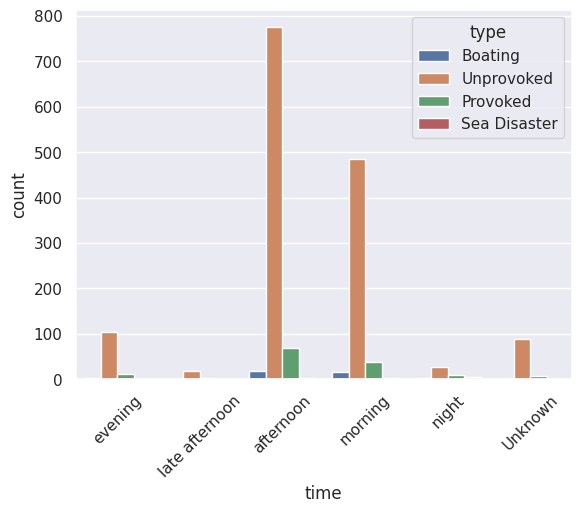

In [159]:
sns.set(style="darkgrid")
sns.countplot(data=df, x='time', hue='type')
plt.xticks(rotation=45)
plt.show()

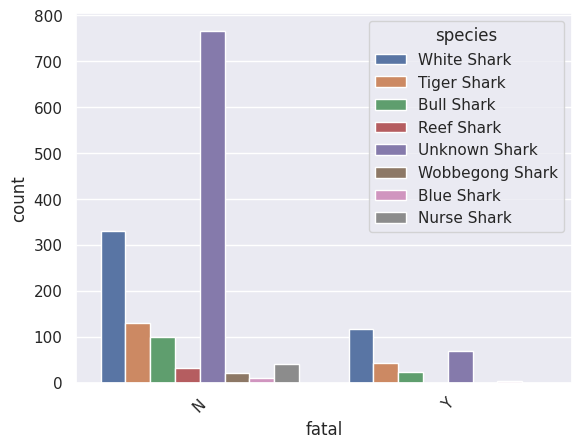

In [160]:
sns.set(style="darkgrid")
sns.countplot(data=df, x='fatal', hue='species')
plt.xticks(rotation=45)
plt.show()

----------------

## Model training

Now lest train our model. We are going to use a linea

In [161]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [170]:
label_encoder = LabelEncoder()
X_encoded = df.copy()
for col in df:
    X_encoded[col] = label_encoder.fit_transform(df[col])

In [163]:
X = X_encoded[['type', 'country', 'activity', 'sex', 'time', 'species']] 
y = X_encoded['fatal'] 

In [164]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [165]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier()

In [171]:
y_pred = model.predict(X_test)


In [167]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8516320474777448


Now will se the importnace for each value

In [168]:
feature_importances = model.feature_importances_
print(feature_importances)

[0.07582372 0.27644899 0.12300508 0.05985304 0.20323242 0.26163676]
